Import needed stuff

In [1]:
import requests
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
from matplotlib import pyplot as plt
import seaborn as sns
import networkscience as ns
import pycountry as pc

Downloading data by http request

In [2]:
reply = requests.get('https://data.europa.eu/euodp/data/storage/f/2020-08-11T140550/Finalised%20mobilities%20started%20in%202018%20-%20KA1.csv')
reply.encoding = 'utf-8'
csv_data = reply.text
df = pd.read_csv(StringIO(csv_data), sep=';',low_memory=False)

## Mobility of Countries
In this section we want to analyze how musch different countries are involved in the Erasmus program.

I am not sure there are enought node to have a sensible analysis of the problem.

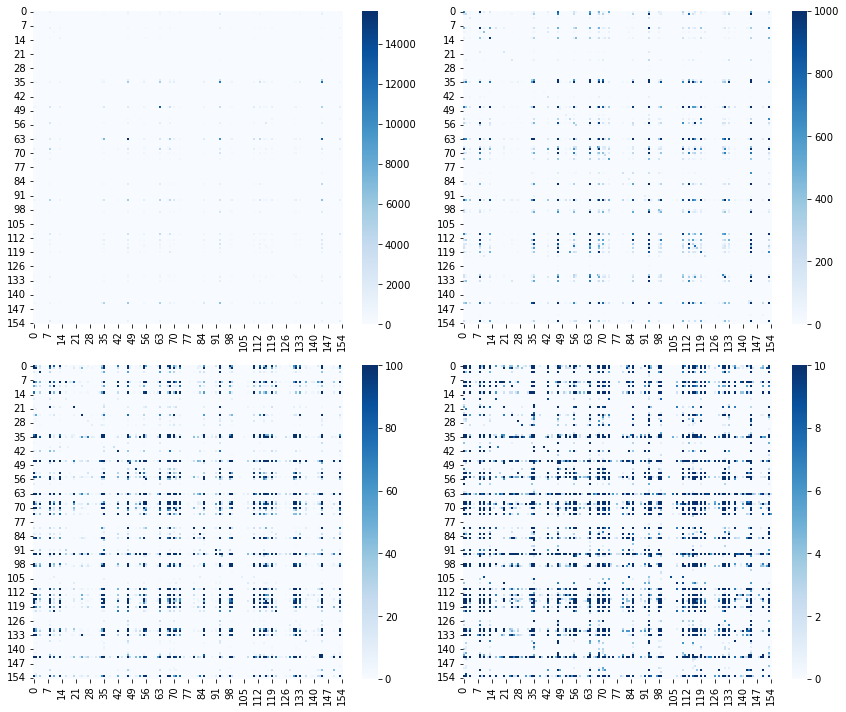

In [3]:
country_df = df[df[df.columns[10]]=='Learner']
country_df = country_df.loc[:, df.columns[np.array((14, 17, 20))]]
country_df.dropna(how='any', inplace=True)
nodes = np.array(list(set.union(set(country_df.loc[:, country_df.columns[0]]), set(country_df.loc[:, country_df.columns[1]]))))
# I don't want it to take forever
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
country_df['SendId'] = (np.array(list(map(lambda x: node_position[x], country_df['Sending Country Code']))))
country_df['RecId']= (np.array(list(map(lambda x: node_position[x], country_df['Receiving Country Code']))))
# Adjacency matrix
country_serie = country_df.groupby(['SendId', 'RecId']).sum()
row = np.array(country_serie.index.get_level_values(1).tolist())
col = np.array(country_serie.index.get_level_values(0).tolist())
val = country_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

def replace_iso3166(alpha):
    try:
        return pc.countries.get(alpha_2=alpha).name
    except:
        return alpha

country_df['Receiving Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), country_df['Receiving Country Code']))))
country_df['Sending Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), country_df['Sending Country Code']))))
nodes_df['Nodes'] = (np.array(list(map(lambda x: replace_iso3166(x), nodes_df['Nodes']))))

ns.visualize_adj(adj_matrix_crs)

I would like to understand if the corresponent undirected unwiegthed graph was symmetric, but it is not

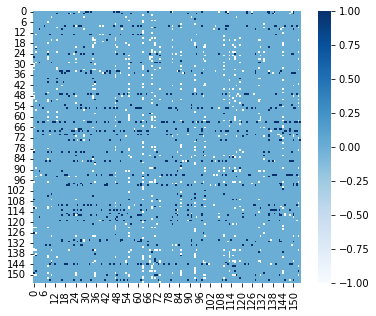

In [4]:
matr = adj_matrix_crs.toarray()
matr[matr>1]=1
matr = matr - matr.T
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(matr, cmap="Blues", ax=ax)
plt.show()


Calculation of the number of components in the network

In [5]:
country_df.rename({'Sending Country Code': 'source', 'Receiving Country Code':'target', 'Participants':'weight'},axis=1, inplace=True)
components = ns.find_components(adj_matrix_crs, nodes_df)
unique, counts = np.unique(components['component'], return_counts=True)
print('Number of components =', len(unique))

Number of components = 1


### Degree distribution

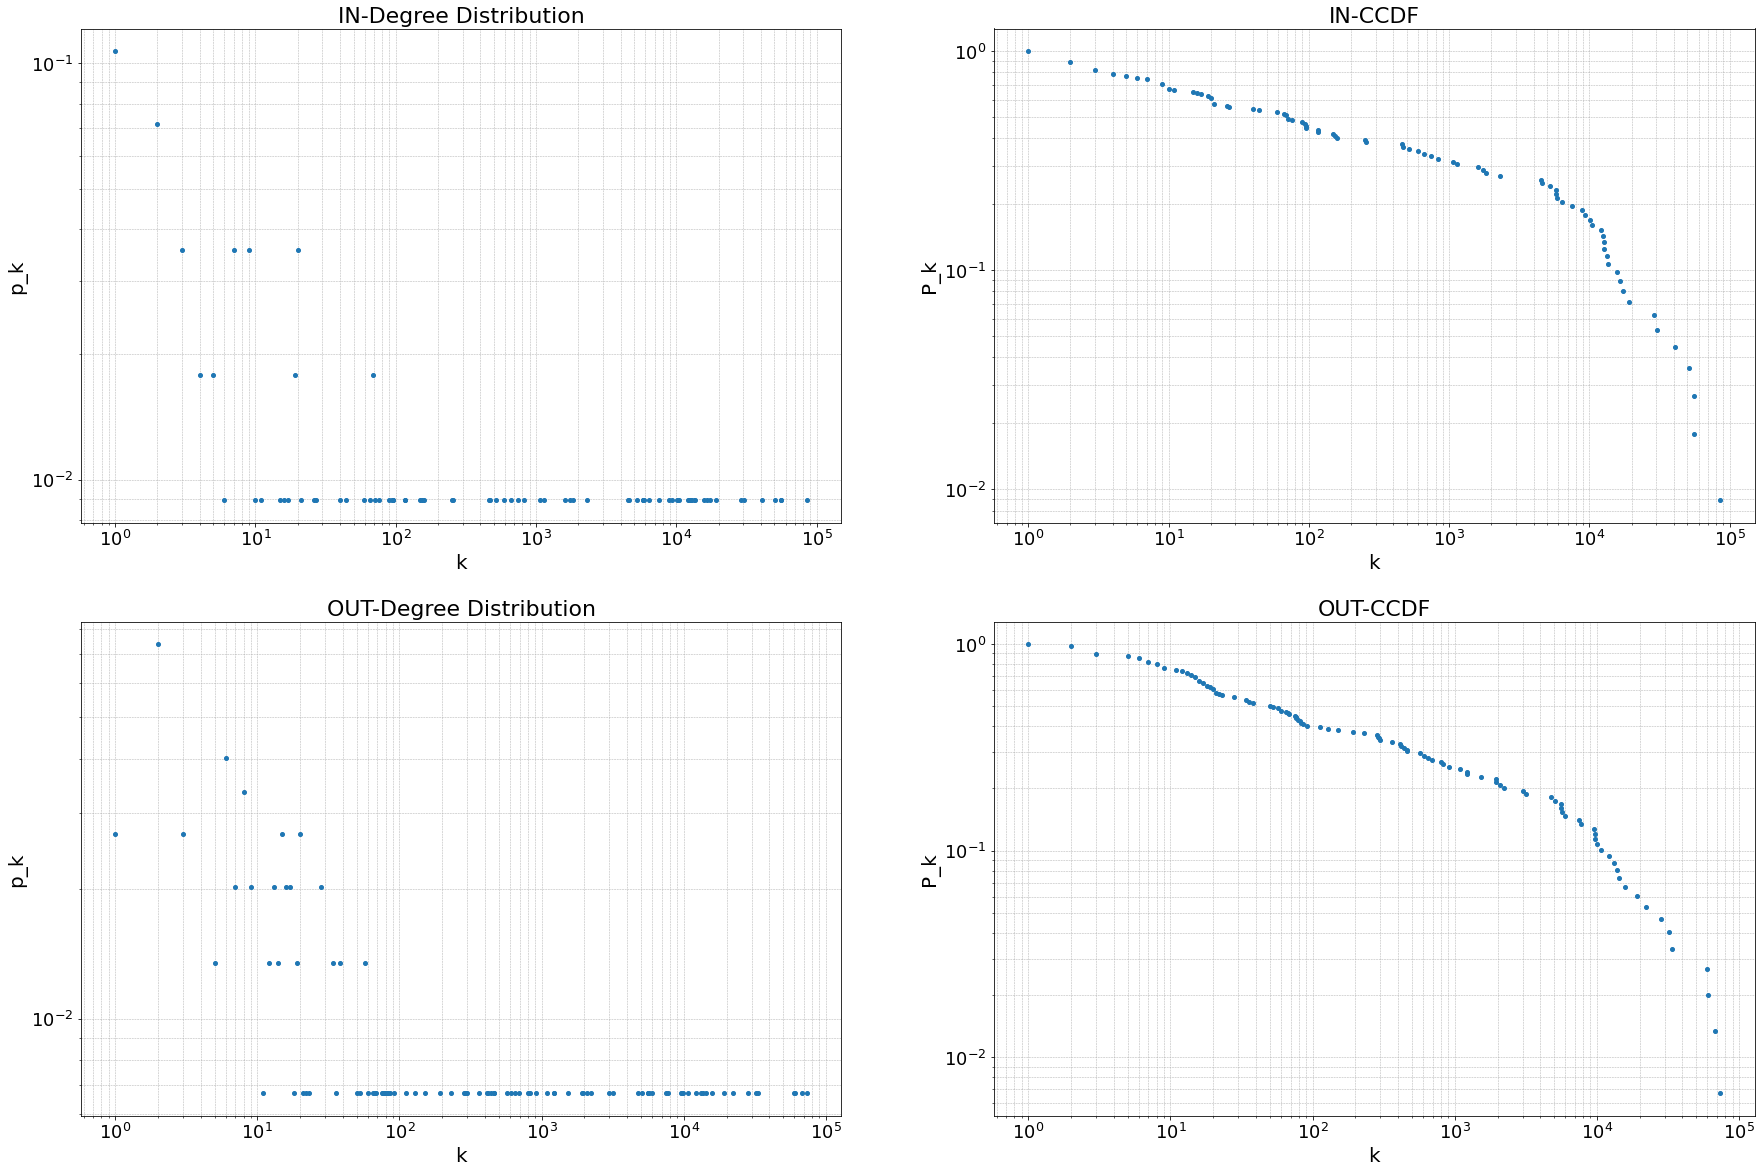

Top 10 for in degree


,Nodes,in degree
63,Spain,85255
35,UK,55556
93,Germany,55489
47,Italy,50912
144,France,40840
68,Poland,30154
110,Portugal,28984
113,Netherlands,19163
34,Ireland,17474
55,Czechia,16559


Top 10 for out degree


,Nodes,out degree
144,France,73481
93,Germany,67772
47,Italy,60222
63,Spain,59413
8,Turkey,33511
68,Poland,32388
35,UK,28448
113,Netherlands,22090
153,Romania,19294
110,Portugal,15750


In [6]:
scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
ns.display_top_n(scores, 10, 'in degree')
ns.display_top_n(scores, 10, 'out degree')

### HITS (NetworkX)

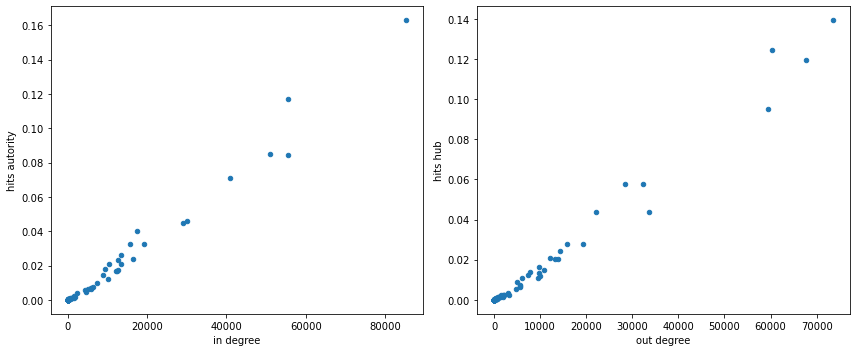

Top 10 for hits hub


,Nodes,hits hub
144,France,0.139283
47,Italy,0.124679
93,Germany,0.119749
63,Spain,0.094932
35,UK,0.057723
68,Poland,0.057705
113,Netherlands,0.043805
8,Turkey,0.043587
153,Romania,0.027973
110,Portugal,0.027626


Top 10 for hits autority


,Nodes,hits autority
63,Spain,0.162843
35,UK,0.117227
47,Italy,0.085113
93,Germany,0.084523
144,France,0.071154
68,Poland,0.046151
110,Portugal,0.044684
34,Ireland,0.040060
85,Belgium,0.032396
113,Netherlands,0.032326


In [7]:
df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'hits hub')
ns.display_top_n(scores, 10, 'hits autority')

### PageRank (NetworkX)

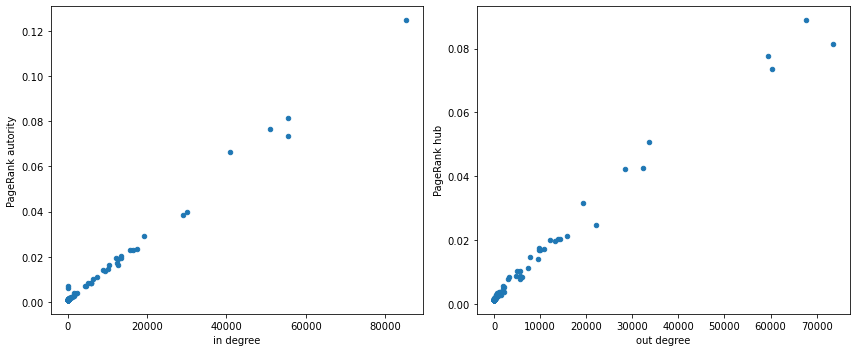

Top 10 for PageRank hub


,Nodes,PageRank hub
93,Germany,0.088870
144,France,0.081390
63,Spain,0.077764
47,Italy,0.073692
8,Turkey,0.050792
68,Poland,0.042699
35,UK,0.042150
153,Romania,0.031626
113,Netherlands,0.024640
110,Portugal,0.021385


Top 10 for PageRank autority


,Nodes,PageRank autority
63,Spain,0.124574
93,Germany,0.081602
47,Italy,0.076687
35,UK,0.073659
144,France,0.066544
68,Poland,0.040025
110,Portugal,0.038717
113,Netherlands,0.029240
34,Ireland,0.023405
55,Czechia,0.023160


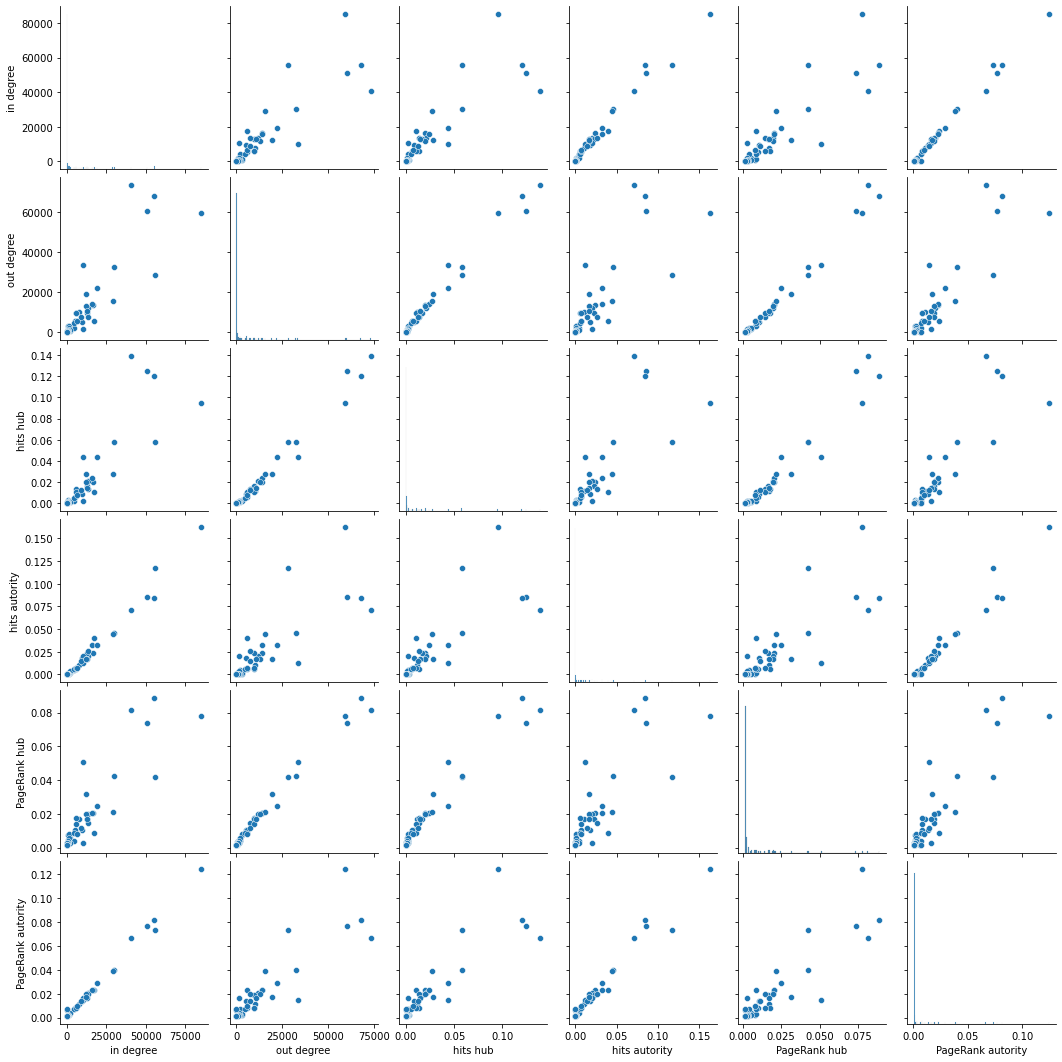

In [8]:
df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'PageRank hub')
ns.display_top_n(scores, 10, 'PageRank autority')

sns.pairplot(scores)
plt.show()

In [9]:
def create_position(score_df, label):
    scores = score_df.sort_values(label, ascending=False)
    scores[label+' position']= (np.arange(len(scores.index))+1)
    return scores

scores = create_position(scores, 'in degree')
scores = create_position(scores, 'out degree')
scores = create_position(scores, 'hits hub')
scores = create_position(scores, 'hits autority')
scores = create_position(scores, 'PageRank hub')
scores = create_position(scores, 'PageRank autority')
scores.sort_index(inplace=True)

In [10]:
n = 40
pd.set_option('display.max_rows', n)
display(scores.sort_values('PageRank autority', ascending=False)[['Nodes', 'in degree', 'in degree position', 'hits autority', 'hits autority position', 'PageRank autority', 'PageRank autority position']].head(n))
display(scores.sort_values('PageRank hub', ascending=False)[['Nodes', 'out degree', 'out degree position', 'hits hub', 'hits hub position', 'PageRank hub', 'PageRank hub position']].head(n))

,Nodes,in degree,in degree position,hits autority,hits autority position,PageRank autority,PageRank autority position
63,Spain,85255,1,0.162843,1,0.124574,1
93,Germany,55489,3,0.084523,4,0.081602,2
47,Italy,50912,4,0.085113,3,0.076687,3
35,UK,55556,2,0.117227,2,0.073659,4
144,France,40840,5,0.071154,5,0.066544,5
68,Poland,30154,6,0.046151,6,0.040025,6
110,Portugal,28984,7,0.044684,7,0.038717,7
113,Netherlands,19163,8,0.032326,10,0.029240,8
34,Ireland,17474,9,0.040060,8,0.023405,9
55,Czechia,16559,10,0.023774,12,0.023160,10


,Nodes,out degree,out degree position,hits hub,hits hub position,PageRank hub,PageRank hub position
93,Germany,67772,2,0.119749,3,0.088870,1
144,France,73481,1,0.139283,1,0.081390,2
63,Spain,59413,4,0.094932,4,0.077764,3
47,Italy,60222,3,0.124679,2,0.073692,4
8,Turkey,33511,5,0.043587,8,0.050792,5
68,Poland,32388,6,0.057705,6,0.042699,6
35,UK,28448,7,0.057723,5,0.042150,7
153,Romania,19294,9,0.027973,9,0.031626,8
113,Netherlands,22090,8,0.043805,7,0.024640,9
110,Portugal,15750,10,0.027626,10,0.021385,10


### Assortativity
We have to check if this disassortativity is due to structural reason, because it looks weird. It is almost the opposit of what we saw for the complete network.

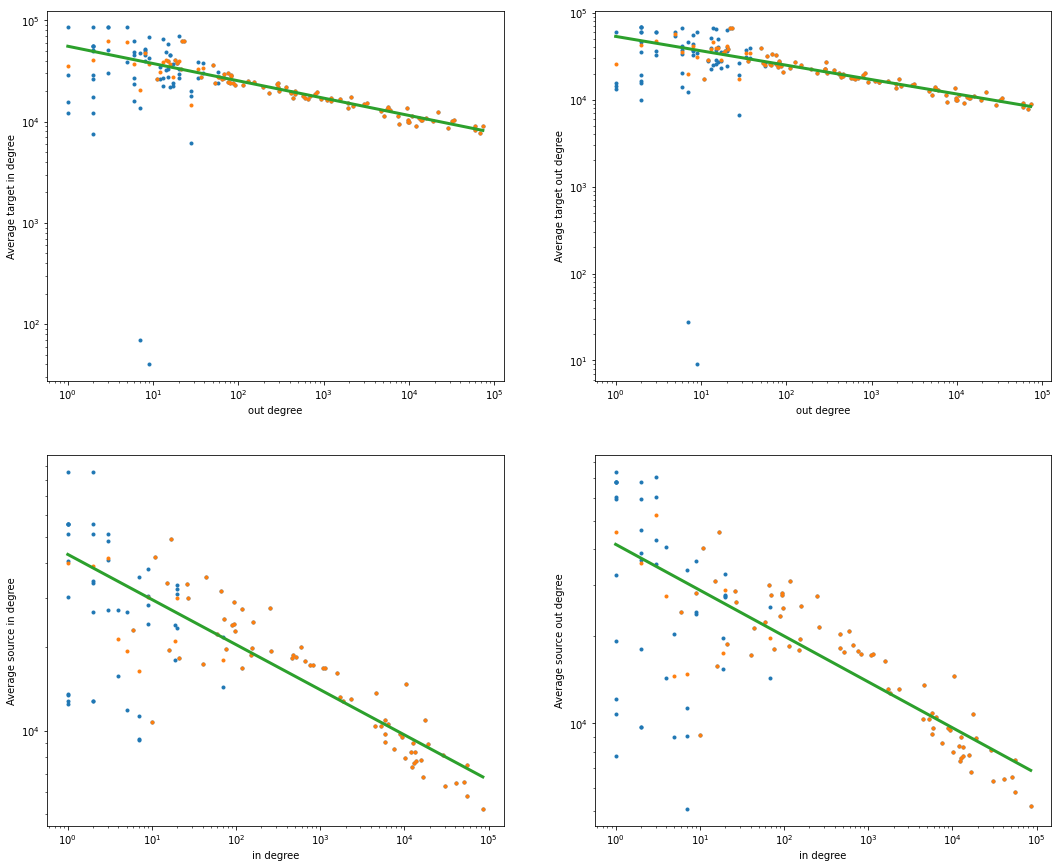

(-0.1709131474314809,
 -0.16566416781192514,
 -0.16258008251223896,
 -0.15802291954725187)

In [11]:
edges = country_df[['source','target']].copy()
ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True)

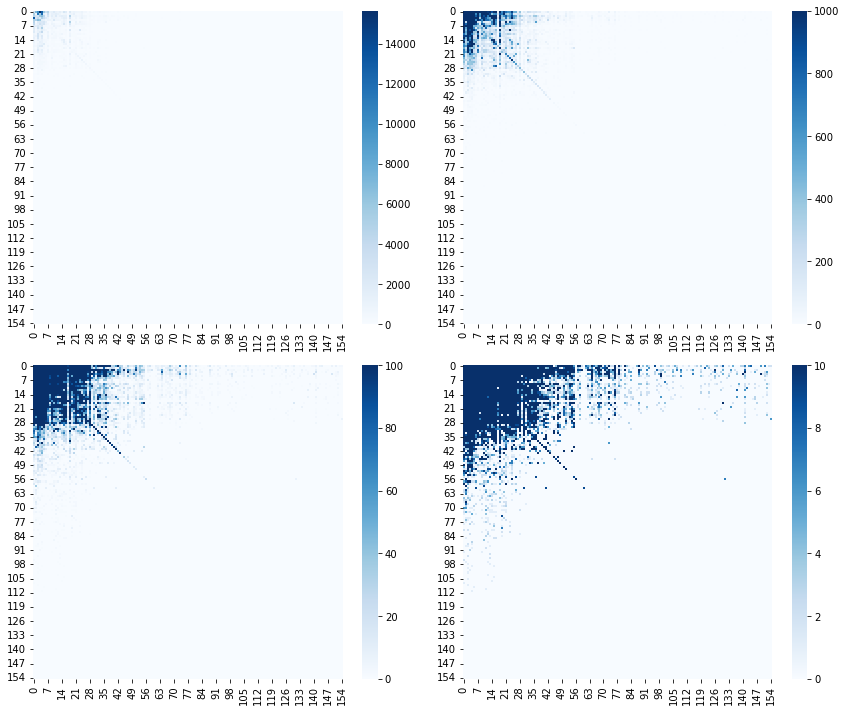

In [12]:
# label = 'PageRank autority position'
label = 'in degree position'
c = country_df.drop(['SendId', 'RecId'],axis=1)
another_order = scores[['Nodes', label]].copy()
another_order[label] = another_order[label] - 1
another_order.rename({'Nodes':'source', label: 'source ID'}, axis=1, inplace=True)
c = pd.merge(c, another_order, on="source")
another_order.rename({'source':'target', 'source ID': 'target ID'}, axis=1, inplace=True)
c = pd.merge(c, another_order, on="target")
c_serie = c.groupby(['source ID', 'target ID']).sum()
row = np.array(c_serie.index.get_level_values(1).tolist())
col = np.array(c_serie.index.get_level_values(0).tolist())
val = c_serie.values
or_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

ns.visualize_adj(or_adj)

The plot highlights differences between the adjacency matrix and the transpose one. It can explain disassortativity.

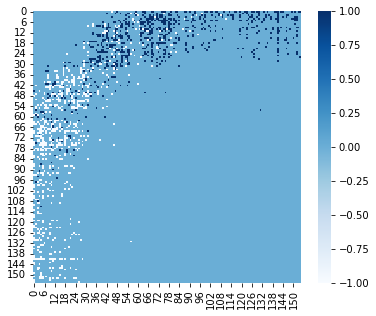

In [13]:
matr = or_adj.toarray()
matr[matr>1]=1
matr = matr - matr.T
fig, ax = plt.subplots(figsize=(6,5))
sns.heatmap(matr, cmap="Blues", ax=ax)
plt.show()

This is only a draft version of community detection

In [14]:
import networkx as nx
# import community

G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix_crs)
p = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)
node_comm = nodes_df.copy()

node_comm['Community']=np.zeros(len(node_comm.index),dtype='int8')
for i, set in enumerate(p):
    for element in set:
        node_comm.iat[element, 1]=i
for i, set in enumerate(p):
    display(node_comm[node_comm['Community']==i])


,Nodes,Community
4,Cayman Islands,0
5,Costa Rica,0
9,"Taiwan, Province of China",0
11,Uruguay,0
12,Iraq,0
...,...,...
146,"Bolivia, Plurinational State of",0
147,Turkmenistan,0
148,Cuba,0
149,Thailand,0


,Nodes,Community
2,Bhutan,1
3,Russian Federation,1
10,Georgia,1
13,Bulgaria,1
14,Timor-Leste,1
16,Azerbaijan,1
20,Bosnia and Herzegovina,1
24,Iceland,1
27,Egypt,1
29,Liechtenstein,1


,Nodes,Community
0,Lithuania,2
19,Malaysia,2
25,Chile,2
26,Canada,2
30,Nigeria,2
35,UK,2
41,Peru,2
44,South Africa,2
52,Uganda,2
55,Czechia,2


,Nodes,Community
7,Rwanda,3
76,"Congo, The Democratic Republic of the",3
85,Belgium,3
86,Aruba,3
88,French Polynesia,3
103,Nicaragua,3
128,Lebanon,3


,Nodes,Community
6,Afghanistan,4
8,Turkey,4
17,Montserrat,4
40,Sint Maarten (Dutch part),4
82,China,4
84,Bangladesh,4


,Nodes,Community
1,Norway,5
21,Greenland,5
48,"Palestine, State of",5
142,Jordan,5
150,Tunisia,5


## Geographic Heat map 

<AxesSubplot:>

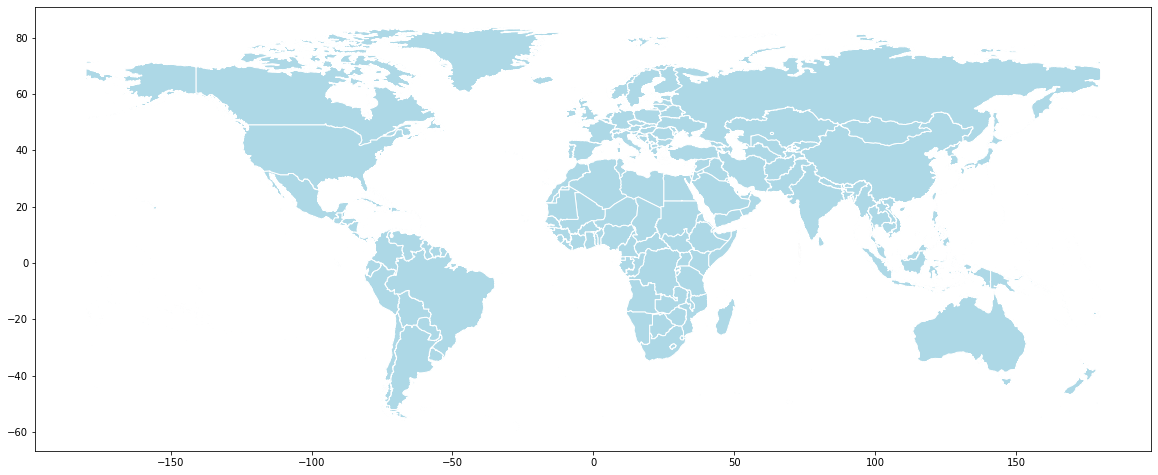

In [15]:
import geopandas as gpd

# Setting the path to the shapefile
# shapefile = 'ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp'

# Read shapefile using Geopandas
# geo_df = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
geo_df = gpd.read_file('countries.geojson')

# geo_df['geometry'][geo_df['ADMIN'] == 'France'] = geo2_df['geometry'][geo2_df['ADMIN'] == 'France']
def replace_iso2(alpha):
    try:
        return pc.countries.get(alpha_3=alpha).alpha_2
    except:
        return alpha
    
geo_df['iso2_code']= (np.array(list(map(lambda x: replace_iso2(x), geo_df['ISO_A3']))))

# Rename columns
geo_df.columns = ['country', 'country_code', 'geometry', 'iso2_code']

# Drop row for 'Antarctica'. It takes a lot of space in the map and is not of much use
geo_df = geo_df.drop(geo_df.loc[geo_df['country'] == 'Antarctica'].index)

# Print the map
geo_df.plot(figsize=(20, 20), edgecolor='white', linewidth=1, color='lightblue')

C:\Users\tomma\AppData\Local\Temp/ipykernel_4164/2872757169.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_df['iso2_code'][geo_df['country'] == 'United Kingdom'] = 'UK'
C:\Users\tomma\AppData\Local\Temp/ipykernel_4164/2872757169.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_df['iso2_code'][geo_df['country'] == 'Greece'] = 'EL'
C:\Users\tomma\AppData\Local\Temp/ipykernel_4164/2872757169.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

(-198.0, 198.0000000000002, -66.62809417064985, 90.78944326365011)

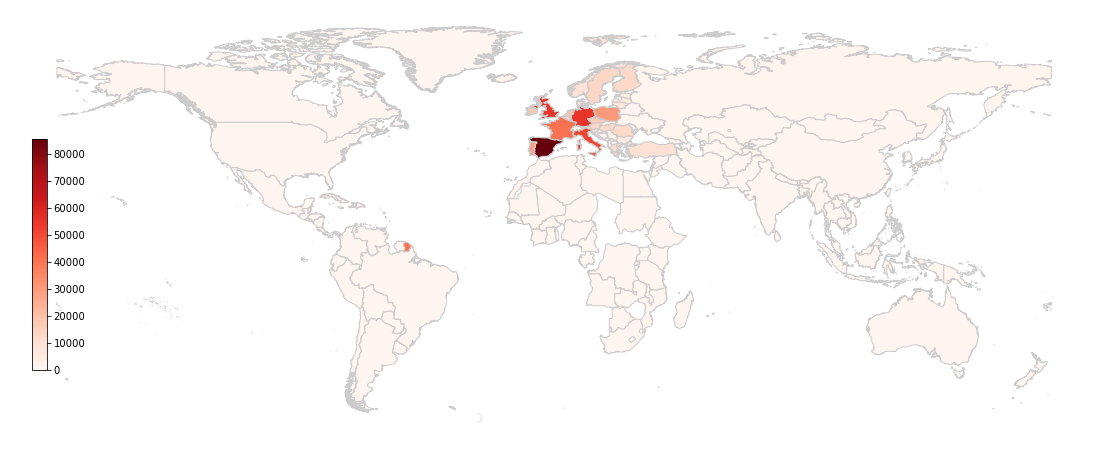

In [16]:
# import country_converter as coco

fig, ax = plt.subplots(1, figsize=(20, 8))

# adding code country to scores dataframe
countries_codes = nodes_df
countries_codes['code'] = nodes
scores_merge = pd.merge(left=countries_codes, right=scores, how='right', left_on='Nodes', right_on='Nodes')

# geo_df contains iso3 codes so we need to convert them to iso2
# geo_df['iso2_code'] = coco.convert(names=list(geo_df['country']), to='ISO2', not_found='NULL')
# geo_df = geo_df.drop(geo_df.loc[geo_df['iso2_code'] == 'NULL'].index)

# in geo_df United Kingdom has code GB, so we have to change it manually
geo_df['iso2_code'][geo_df['country'] == 'United Kingdom'] = 'UK'
geo_df['iso2_code'][geo_df['country'] == 'Greece'] = 'EL'
geo_df['iso2_code'][geo_df['country'] == 'Kosovo'] = 'XK'
geo_df['country'][geo_df['country'] == 'Czech Republic'] = 'Czechia'
geo_df['country'][geo_df['country'] == 'Republic of Serbia'] = 'Serbia'

# adding Switzerland since there is no Erasmus data
sw = {'Nodes':'Switzerland', 'code':'CH', 'in degree':0, 'out degree':0, 'hits hub':0, 'hits autority':0,
       'PageRank hub':0, 'PageRank autority':0, 'in degree position':0,
       'out degree position':0, 'hits hub position':0, 'hits autority position':0,
       'PageRank hub position':0, 'PageRank autority position':0}
scores_merge = scores_merge.append(sw, ignore_index = True)

merged_df = pd.merge(left=geo_df, right=scores_merge, how='right', left_on='iso2_code', right_on='code')
merged_df.dropna(subset=['Nodes'], inplace=True)
merged_df.plot(column='in degree', ax=ax, edgecolor='0.8', linewidth=1, cmap='Reds')

sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=merged_df['in degree'].min(), 
                                              vmax=merged_df['in degree'].max()), cmap='Reds')

# Empty array for the data range
sm._A = []

# Add the colorbar to the figure
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)
ax.axis('off')

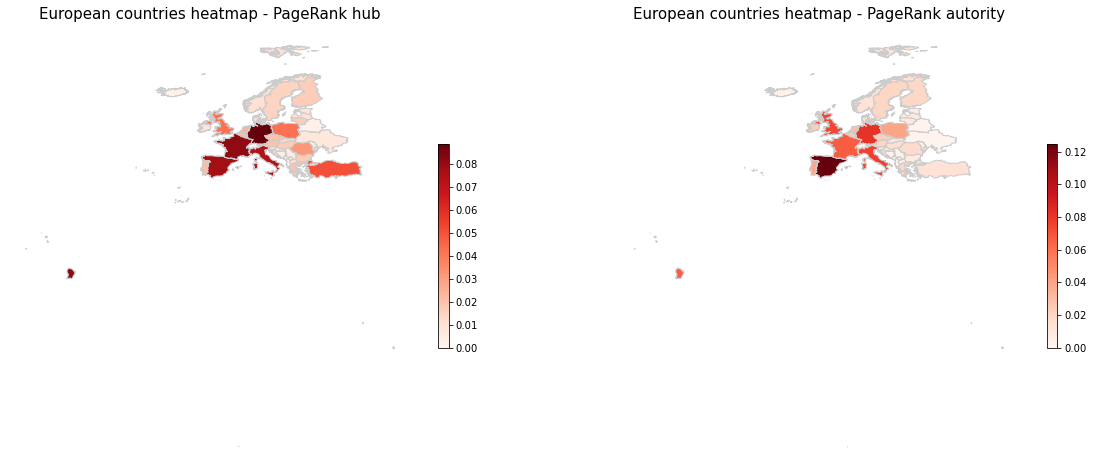

In [17]:
european_countries = ['Germany', 'United Kingdom', 'France', 'Italy', 'Spain', 'Ukraine', 'Poland', 'Romania', 
                'Netherlands', 'Belgium', 'Czechia', 'Greece', 'Portugal', 'Sweden', 'Hungary', 
                'Belarus', 'Austria', 'Serbia', 'Switzerland', 'Bulgaria', 'Denmark', 'Finland', 'Slovakia', 'Norway',
                'Ireland', 'Croatia', 'Moldova', 'Bosnia and Herzegovina', 'Albania', 'Lithuania', 'Macedonia', 
                'Slovenia', 'Latvia', 'Estonia', 'Montenegro', 'Luxembourg', 'Malta', 'Iceland', 'Andorra', 'Monaco', 
                'Liechtenstein', 'Kosovo', 'Turkey']
# Russia has not been taken in consideration since it was too big to show and has very low exchanges

european_df = merged_df[merged_df['country'].isin(european_countries)]

# deg_list = ['in degree', 'out degree', 'PageRank hub', 'PageRank autority']
#fig4, ax4 = plt.subplots(1,4, figsize=(20,15))
deg_list = ['PageRank hub', 'PageRank autority']
fig4, ax4 = plt.subplots(1,2, figsize=(20,15))

for i in range(len(deg_list)):
    european_df.plot(column=deg_list[i], ax=ax4[i], edgecolor='0.8', linewidth=1, cmap='Reds')
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=european_df[deg_list[i]].min(), 
                                              vmax=european_df[deg_list[i]].max()), cmap='Reds')
    ax4[i].axis('off')
    fig4.colorbar(sm, ax=ax4[i], shrink=0.25)
    ax4[i].set_title('European countries heatmap - ' + deg_list[i], fontsize=15)
    
# ax4 = np.reshape(ax4, (2,2))
plt.savefig('eu_pagerank.png')

GeoPlot for Communities

C:\Users\tomma\AppData\Local\Temp/ipykernel_4164/373270636.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_comm['Nodes'][node_comm['Nodes'] == 'Moldova, Republic of'] = 'Moldova'
C:\Users\tomma\AppData\Local\Temp/ipykernel_4164/373270636.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_comm['Nodes'][node_comm['Nodes'] == 'North Macedonia'] = 'Macedonia'
C:\Users\tomma\AppData\Local\Temp/ipykernel_4164/373270636.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

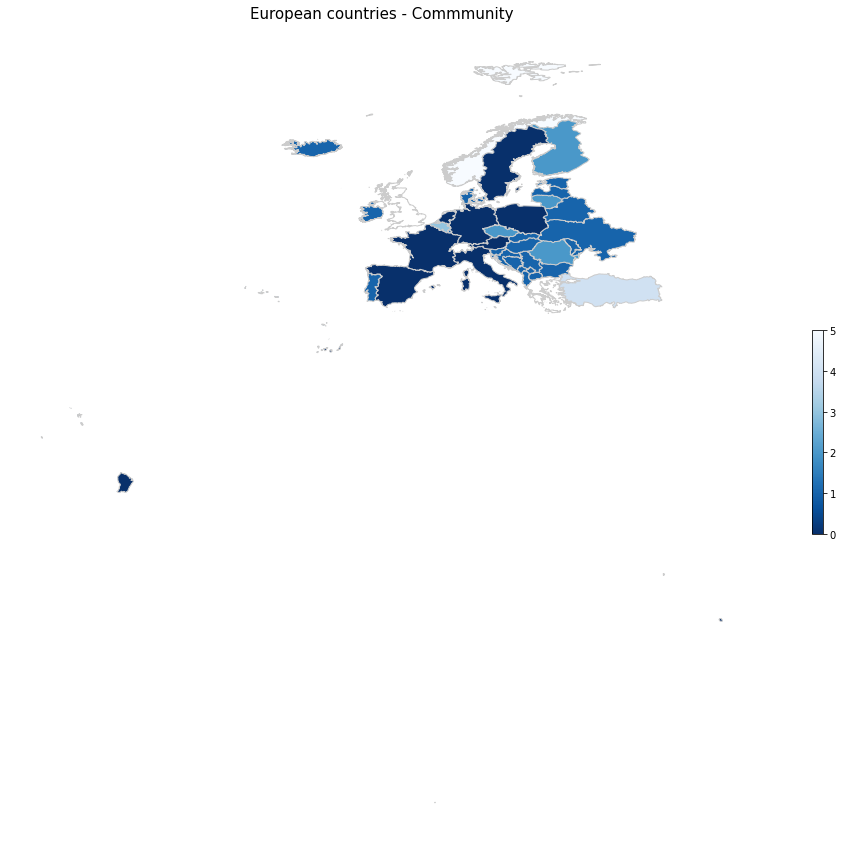

In [18]:
import matplotlib.patches as mpatches

node_comm['Nodes'][node_comm['Nodes'] == 'Moldova, Republic of'] = 'Moldova'
node_comm['Nodes'][node_comm['Nodes'] == 'North Macedonia'] = 'Macedonia'
node_comm['Nodes'][node_comm['Nodes'] == 'XK'] = 'Kosovo'

eu_comm = node_comm[node_comm['Nodes'].isin(european_countries)]
european_df['Community'] = eu_comm['Community']

fig5, ax5 = plt.subplots(figsize=(20,15))
european_df.plot(column='Community', ax=ax5, edgecolor='0.8', linewidth=1, cmap='Blues_r')
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=european_df['Community'].min(), 
                                              vmax=european_df['Community'].max()), cmap='Blues_r')
fig5.colorbar(sm, ax=ax5, shrink=0.25)
ax5.axis('off')
ax5.set_title('European countries - Commmunity', fontsize=15)

plt.savefig('eu_community.png')